# IMDb
**Here we explore how to inject confounding bias into binary classification problems. **


To do so, we consider a standard binary classification problem with feature matrix $X$ and labels $y$. We modify the training sample to inject a confounding bias.
- Select a feature $f$ that has low chi2 value and occurs at least $N$ times but no more than $M$ times.
- Sample a training set $D$ in which $f$ and $y$ have a specified correlation
- Plot test accuracy as correlation varies.

The experiments below use IMDB sentiment classification, where genre is presumed to be a confounder.

We also look for examples of Simpson's Paradox. E.g., a coefficient as negative value when fit on all data, but has positive value in each genre.

# Table of Contents

1. [Dataset][1]
  1. [Download data from Dropbox][2]
  2. [Load data from files][3]
2. [Experiments][4]
  1. [Load models][5]
  2. [Experiment helper functions][6]
  3. [Correlation stats][7]
  4. [Confounding experiments][8]
  5. [Export plots][9]
  6. [Simpson's paradox][10]
  7. [Study effect of C value on accuracy][11]
  8. [Change in model coefficients][12]
  9. [Top terms table][13]
[1]: #Dataset
[2]: #Download-data-from-Dropbox
[3]: #Load-data-from-files
[4]: #Experiments
[5]: #Load-models
[6]: #Experiment-helper-functions
[7]: #Correlation-stats
[8]: #Confounding-experiments
[9]: #Export-plots
[10]: #Simpson's-paradox
[11]: #Study-effect-of-C-value-on-accuracy
[12]: #Change-in-model-coefficients
[13]: #Top-terms-table

In [12]:
import scipy.sparse as sparse
import glob
import numpy as np
import pickle
import os.path

from scipy.stats import pearsonr, sem
from collections import Counter, defaultdict
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import scale

In [13]:
%run confound_plot.py
%run imdb_confounding_experiments.py
%matplotlib inline
%run injecting_bias.py
%run models.py

## Dataset

### Download data from Dropbox

Our data is [stored on Dropbox](https://www.dropbox.com/sh/pcg731664f8h4fy/AADu0H7h0-hh94TNNO43co9Ea/imdb-genres.tgz?dl=1) and its access is protected by a password. If you are interested in using the data for research purposes, please email one of the author to obtain the password. Once you have downloaded and unpacked the data, set the following `DATAPATH` variable to the path where the data is stored.


In [14]:
DATAPATH = '/Users/ustctll/Desktop/dataset'
IMDB = os.path.join(DATAPATH, 'aclImdb')

### Load data from files

lengths: x_train 25000 y_train 25000 c_train 25000
train y distr Counter({1: 12500, 0: 12500}) c distr Counter({0: 20720, 1: 4280})
train y and c distr Counter({'y=1,c=0': 11280, 'y=0,c=0': 9440, 'y=0,c=1': 3060, 'y=1,c=1': 1220})
lengths: x_test 25000 y_test 25000 c_test 25000
test y distr Counter({1: 12500, 0: 12500}) c distr Counter({0: 20363, 1: 4637})
test y and c distr Counter({'y=1,c=0': 11063, 'y=0,c=0': 9300, 'y=0,c=1': 3200, 'y=1,c=1': 1437})
vectorizing training data...
shape= (25000, 18222)
vectorizing testing data...
shape= (25000, 18222)
test instances difficulty: mean=0.164836, std=0.280024
train instances difficulty: mean=0.165705, std=0.285632


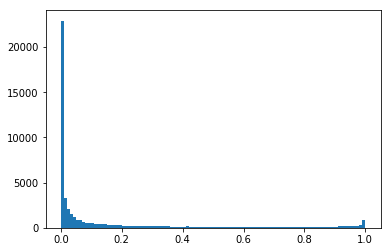

difficulty mean: 0.165270, difficulty variance: 0.080000
  (0, 169)	1
  (0, 496)	1
  (0, 572)	1
  (0, 1645)	1
  (0, 2327)	1
  (0, 2585)	1
  (0, 3040)	1
  (0, 3128)	1
  (0, 3281)	1
  (0, 5654)	1
  (0, 5897)	1
  (0, 6099)	1
  (0, 6241)	1
  (0, 6316)	1
  (0, 7770)	1
  (0, 8197)	1
  (0, 8515)	1
  (0, 8528)	1
  (0, 8767)	1
  (0, 9170)	1
  (0, 9380)	1
  (0, 9518)	1
  (0, 9574)	1
  (0, 11765)	1
  (0, 12095)	1
  (0, 12595)	1
  (0, 12615)	1
  (0, 12983)	1
  (0, 13091)	1
  (0, 13118)	1
  (0, 13359)	1
  (0, 13403)	1
  (0, 13699)	1
  (0, 13973)	1
  (0, 14069)	1
  (0, 14102)	1
  (0, 14172)	1
  (0, 14176)	1
  (0, 14796)	1
  (0, 15696)	1
  (0, 15697)	1
  (0, 15948)	1
  (0, 16184)	1
  (0, 16186)	1
  (0, 16378)	1
  (0, 16482)	1
  (0, 16796)	1
  (0, 17791)	1
  (0, 18141)	1
25000


In [15]:
def read_files(path):
    return [f for f in sorted(glob.glob(path), key=lambda x: int(x[x.rindex('/') + 1:x.index('_')]))]


def read_genres(filename, label='Horror'):
    """ Read genres, making a binary label. """
    genres = []
    for line in open(filename):
        if label in line:
            genres.append(1)
        else:
            genres.append(0)            
    return genres

class Data(object):
    pass

def read_imdb_text(path):
    x_train = read_files(path + '/train/pos/*.txt')
    y_train = [1] * len(x_train)
    c_train = read_genres(path + '/train/urls_pos.txt.genres')
    x_train.extend(read_files(path + '/train/neg/*.txt'))
    y_train.extend([0] * (len(x_train) - len(y_train)))    
    c_train.extend(read_genres(path + '/train/urls_neg.txt.genres'))
    print('lengths: x_train %d y_train %d c_train %d' % (len(x_train), len(y_train), len(c_train)))
    print('train y distr', Counter(y_train), 'c distr', Counter(c_train))
    print('train y and c distr', Counter(['y=%d,c=%d' % (y,c) for (y,c) in zip(y_train,c_train)]))
    
    x_test = read_files(path + '/test/pos/*.txt')
    y_test = [1] * len(x_test)
    c_test = read_genres(path + '/test/urls_pos.txt.genres')                                                              
    x_test.extend(read_files(path + '/test/neg/*.txt'))
    y_test.extend([0] * (len(x_test) - len(y_test)))
    c_test.extend(read_genres(path + '/test/urls_neg.txt.genres'))
    print('lengths: x_test %d y_test %d c_test %d' % (len(x_test), len(y_test), len(c_test)))
    print('test y distr', Counter(y_test), 'c distr', Counter(c_test))
    print('test y and c distr', Counter(['y=%d,c=%d' % (y,c) for (y,c) in zip(y_test,c_test)]))
    
    vectorizer = CountVectorizer(binary=True, min_df=10, stop_words='english')
    print('vectorizing training data...')
    X_train = vectorizer.fit_transform(open(f).read() for f in x_train)
    print('shape=', X_train.shape)
    print('vectorizing testing data...')
    X_test = vectorizer.transform(open(f).read() for f in x_test)
    print('shape=', X_test.shape)

    data = Data()
    data.train_x = X_train
    data.train_y = np.array(y_train)
    data.train_c = np.array(c_train)
    data.test_x = X_test
    data.test_y = np.array(y_test)
    data.test_c = np.array(c_test)
    #data.vectorizer = vectorizer
    data.feature_names = np.array(vectorizer.get_feature_names())
    
    clf = lr(data.train_x, data.train_y, None, None, None)
    pred_proba = clf.predict_proba(data.test_x)
    data.test_d = np.array([1 - y_prob[y_true] for y_prob, y_true in zip(pred_proba, data.test_y)])
    print('test instances difficulty: mean=%f, std=%f' % (np.mean(data.test_d), np.std(data.test_d)))
    
    clf = lr(data.test_x, data.test_y, None, None, None)
    pred_proba = clf.predict_proba(data.train_x)
    data.train_d = np.array([1 - y_prob[y_true] for y_prob, y_true in zip(pred_proba, data.train_y)])
    print('train instances difficulty: mean=%f, std=%f' % (np.mean(data.train_d), np.std(data.train_d)))
    
    all_difficulties = np.hstack([data.train_d, data.test_d])
    data.d_mean = np.mean(all_difficulties)
    data.d_std = np.var(all_difficulties)
    nbins = 100
    data.hist, data.bin_edges = np.histogram(all_difficulties, bins=nbins)
    plt.hist(all_difficulties, bins=nbins)
    plt.show()
    print('difficulty mean: %f, difficulty variance: %f' % (data.d_mean, data.d_std))
    print(data.train_x[0])
    print(data.train_x.shape[0])
    return data

data = read_imdb_text(IMDB)

## Experiments

### Load models

In [7]:
%run models.py
backdoor_adjustment = lambda x,y,z,t,u: backdoor_adjustment_var_C(x,y,z,1.,t,u)
backdoor_adjustment_Z10 = lambda x,y,z,t,u: backdoor_adjustment_var_C(x,y,z,10,t,u)

<Figure size 432x288 with 0 Axes>

### Experiment helper functions

In [8]:
def do_confounding_trials(models, data, ntrials, rand):  
    """ Do several random trials in which we sample data with a confounding variable. 
    Plot the average accuracies as confounding bias increases.
    """
    test_biases = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
    train_biases = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
    
#     test_biases = [.1,.5,.9]
#     train_biases = [.1,.5,.9]
    
    corr_diffs = []
    accuracies = defaultdict(lambda: defaultdict(lambda: []))
    idx_horror = np.where(data.feature_names == 'horror')
    
    for train_bias in train_biases:
        for test_bias in test_biases:
            for ti in range(ntrials):
                # Sample training and testing indices.
                test_idx = make_confounding_data(X=data.test_x, y=data.test_y, c=data.test_c,
                                                pos_prob=.5, bias=test_bias, size=1400, rand=rand)  
                test_corr = pearsonr(data.test_y[test_idx], data.test_c[test_idx])[0]
                train_idx = make_confounding_data(X=data.train_x, y=data.train_y, c=data.train_c,
                                                  pos_prob=.5, bias=train_bias, size=1500, rand=rand)   
                train_corr = pearsonr(data.train_y[train_idx], data.train_c[train_idx])[0]
                corr_diff = round(train_corr - test_corr, 1)
                if ti == 0:
                    corr_diffs.append(corr_diff)
                    print('train_bias=', train_bias, 'train_corr=', train_corr,
                          'test_bias=', test_bias, 'test_corr=', test_corr,
                          'corr_diff=', corr_diff)
                    
                # Train and test each model.
                for name, model in models:
                    clf = model(data.train_x[train_idx], data.train_y[train_idx],
                                data.train_c[train_idx], rand, data.feature_names)
                    y_pred = clf.predict(data.test_x[test_idx])
                    y_true = data.test_y[test_idx]
                    for y in range(3):
                        for c in range(3):
                            k = 3*y+c
                            cond = lambda x: (c == 2 or data.test_c[x] == c) and (y == 2 or data.test_y[x] == y)
                            yc_test_idx = [i for i, j in enumerate(test_idx) if cond(j)]
                            accuracies[k][name].append({'test_bias': test_bias, 'train_bias': train_bias,
                                                        'corr_diff': corr_diff,
                                                        'acc': accuracy_score(y_true[yc_test_idx],
                                                                              y_pred[yc_test_idx])})
                        
    return accuracies, corr_diffs, test_biases

In [9]:
def do_confound_expt(data, ntrials=3, models=[('feature_select', feature_select),('logreg', lr),              
                                             ('matching', matching),('backdoor_adjustment', backdoor_adjustment)],
                    confounding_function=do_confounding_trials):                                              
    rand = np.random.RandomState(1234567)                                                                     
    clf = lr(data.train_x, data.train_y, data.train_c, rand, data.feature_names)                              
    print('og testing accuracy=', accuracy_score(data.test_y, clf.predict(data.test_x)))                      
    print('----------------\nExperiments using genre as a confounder:')                                       
    return confounding_function(models, data, ntrials, rand)

### Correlation stats

In [10]:
print('overall training correlation between genre and sentiment:', pearsonr(data.train_y, data.train_c))
print('overall testing correlation between genre and sentiment:', pearsonr(data.test_y, data.test_c))

overall training correlation between genre and sentiment: (-0.19538942865783307, 1.3117890350125089e-213)
overall testing correlation between genre and sentiment: (-0.18143158044850274, 5.659946609783986e-184)


### Confounding experiments

In [11]:
# Plot results for every possible pair y/c with original function make confounding data
models = [('LR', lr), ('M', matching), ('BAZ10', backdoor_adjustment_Z10),
          ('SO', sumout), ('LRS', lr_subsampling), ('BA', backdoor_adjustment)]
accuracies, corr_diffs, test_biases = do_confound_expt(data, ntrials=5, models=models)

og testing accuracy= 0.86064
----------------
Experiments using genre as a confounder:
train_bias= 0.1 train_corr= -0.36383049317775124 test_bias= 0.1 test_corr= -0.38319552617299957 corr_diff= 0.0
train_bias= 0.1 train_corr= -0.36383049317775124 test_bias= 0.2 test_corr= -0.2873966446297496 corr_diff= -0.1
train_bias= 0.1 train_corr= -0.36383049317775124 test_bias= 0.3 test_corr= -0.1915977630864997 corr_diff= -0.2
train_bias= 0.1 train_corr= -0.36383049317775124 test_bias= 0.4 test_corr= -0.09579888154324988 corr_diff= -0.3
train_bias= 0.1 train_corr= -0.36383049317775124 test_bias= 0.5 test_corr= 0.0 corr_diff= -0.4
train_bias= 0.1 train_corr= -0.36383049317775124 test_bias= 0.6 test_corr= 0.09579888154324981 corr_diff= -0.5
train_bias= 0.1 train_corr= -0.36383049317775124 test_bias= 0.7 test_corr= 0.1915977630864997 corr_diff= -0.6
train_bias= 0.1 train_corr= -0.36383049317775124 test_bias= 0.8 test_corr= 0.28739664462974956 corr_diff= -0.7
train_bias= 0.1 train_corr= -0.3638304931

train_bias= 0.9 train_corr= 0.3638304931777513 test_bias= 0.6 test_corr= 0.09579888154324981 corr_diff= 0.3
train_bias= 0.9 train_corr= 0.3638304931777513 test_bias= 0.7 test_corr= 0.1915977630864997 corr_diff= 0.2
train_bias= 0.9 train_corr= 0.3638304931777513 test_bias= 0.8 test_corr= 0.28739664462974956 corr_diff= 0.1
train_bias= 0.9 train_corr= 0.3638304931777513 test_bias= 0.9 test_corr= 0.38319552617299935 corr_diff= -0.0


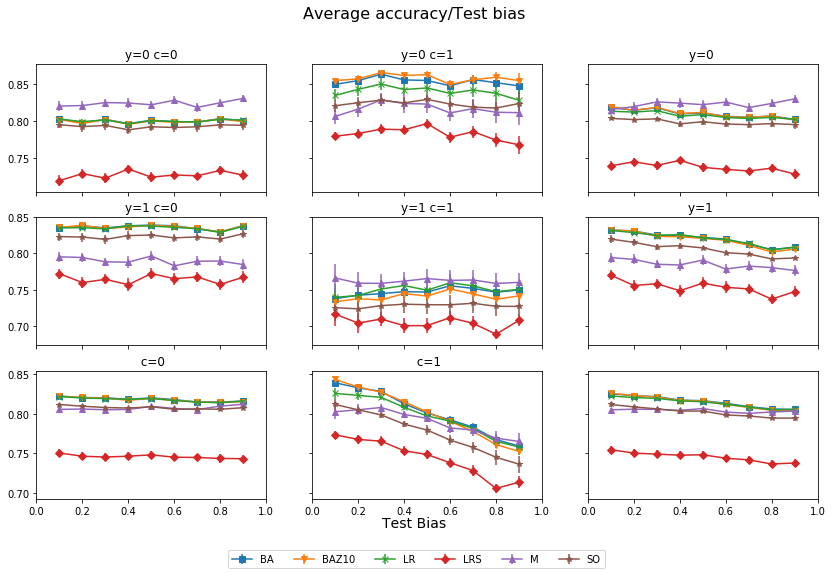

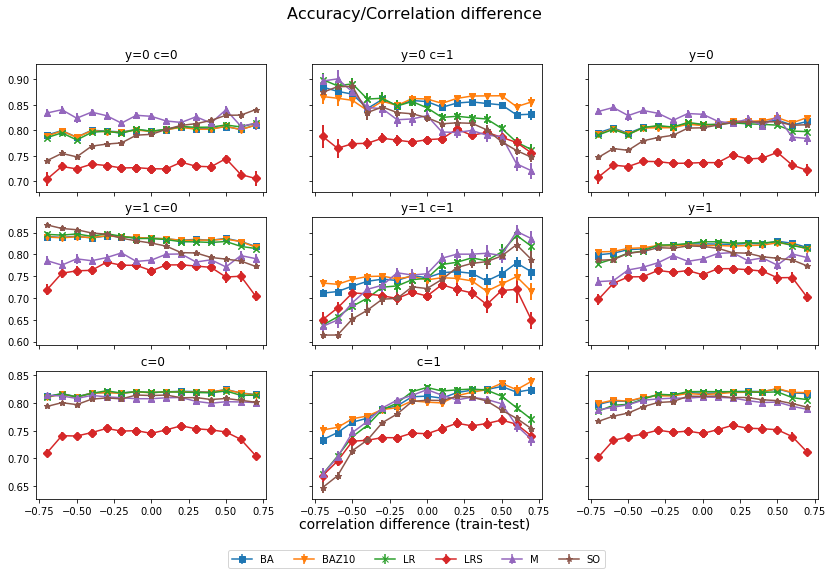

In [12]:
test_bias_axis = (test_biases, 'test_bias', 'Test Bias')
corr_diff_axis = (corr_diffs, 'corr_diff', 'correlation difference (train-test)')

plot_all_accuracies(accuracies, test_bias_axis, title='Average accuracy/Test bias', xlim=[0,1])
plot_all_accuracies(accuracies, corr_diff_axis, title='Accuracy/Correlation difference')

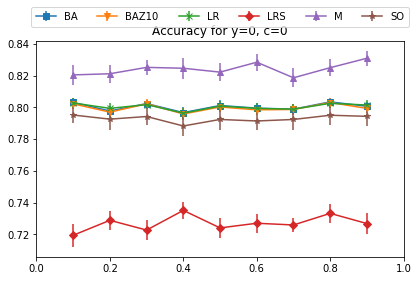

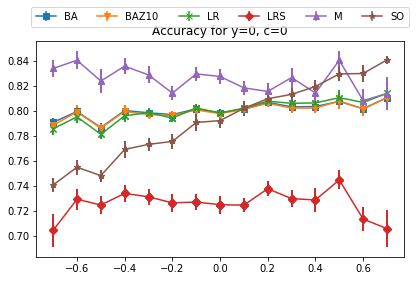

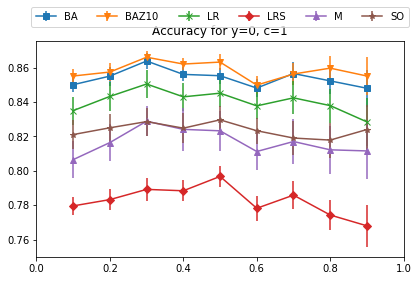

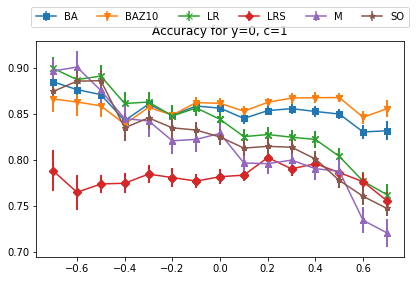

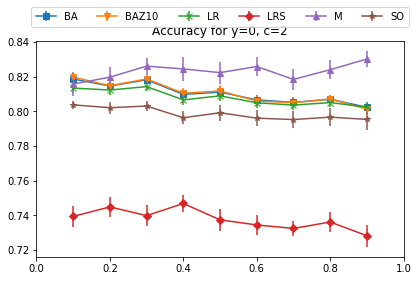

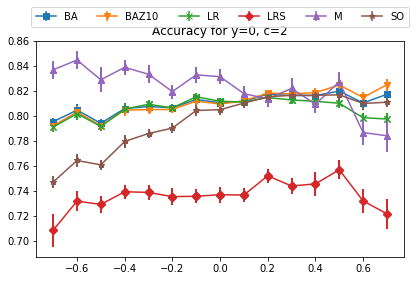

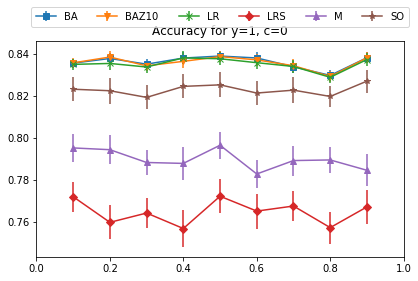

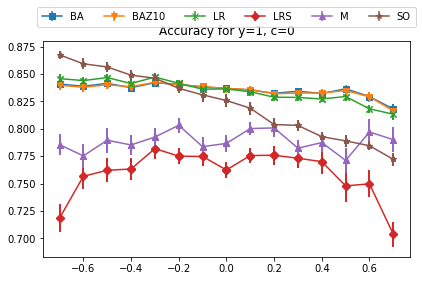

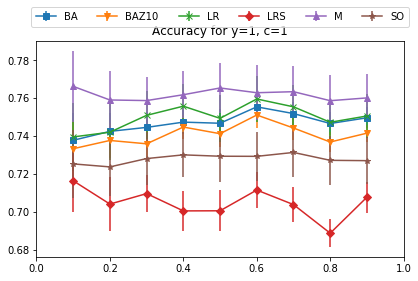

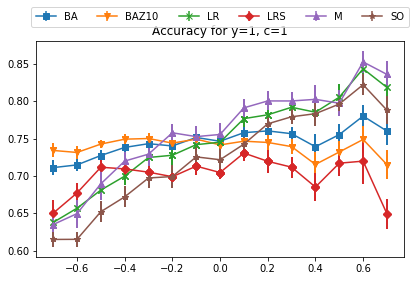

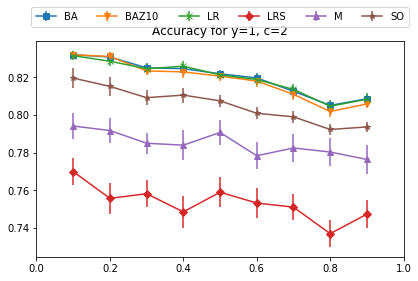

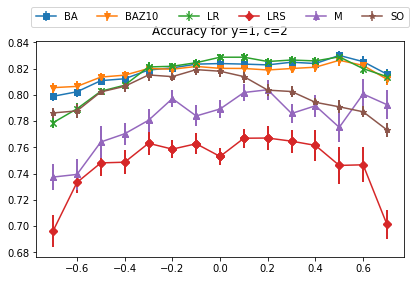

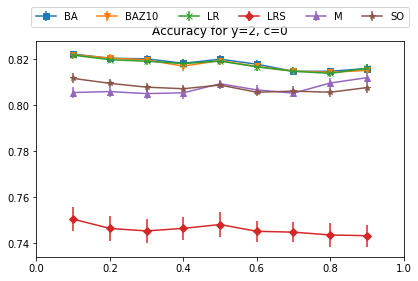

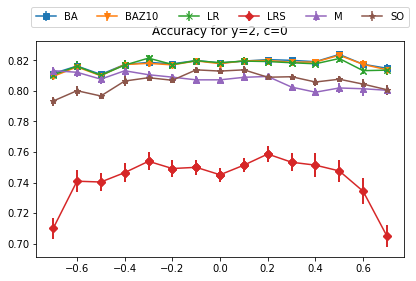

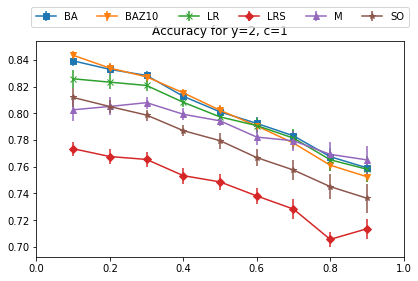

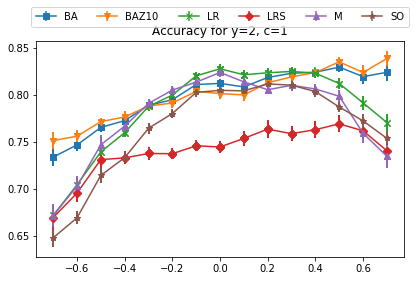

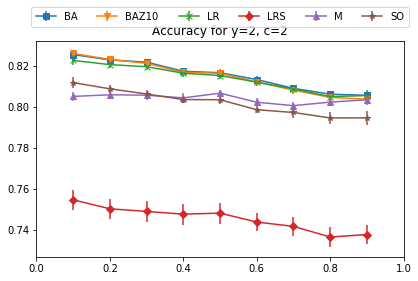

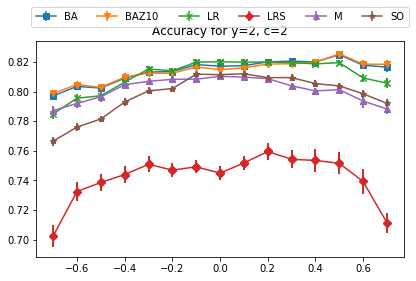

In [13]:
for y in range(3):
    for c in range(3):
        plot_accuracy(accuracies, test_bias_axis, y=y, c=c, xlim=[0,1])
        plot_accuracy(accuracies, corr_diff_axis, y=y, c=c)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


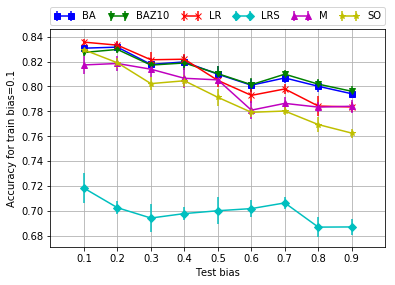

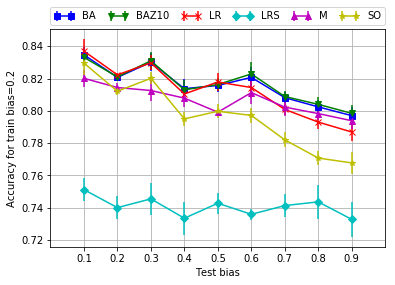

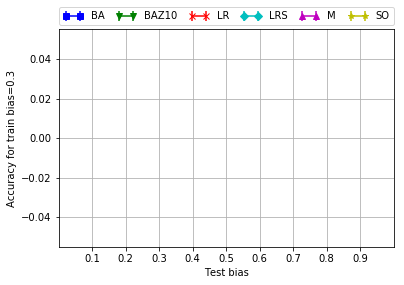

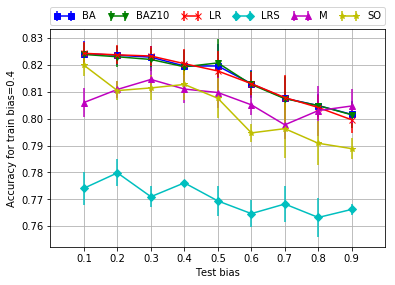

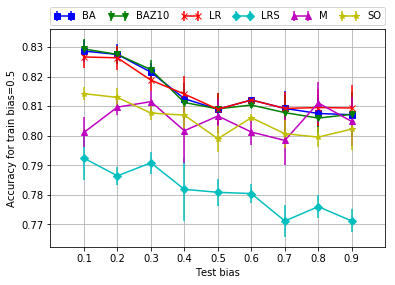

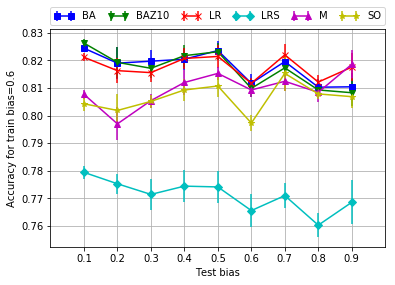

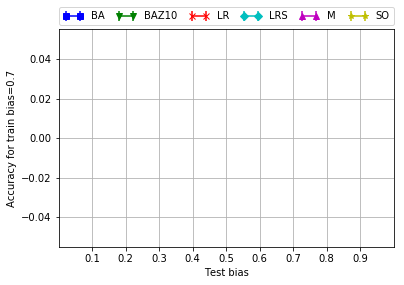

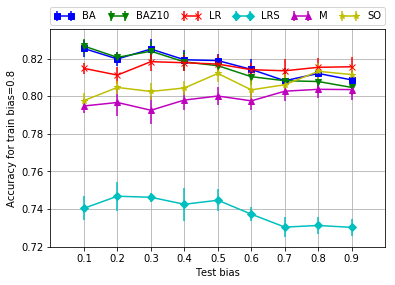

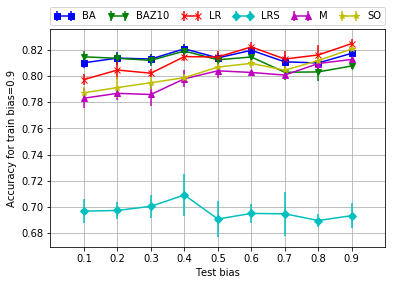

In [14]:
for tr_bias in np.arange(0.1, 1., 0.1):
    ylabel="Accuracy for train bias=%.1f" % tr_bias
    export_plot_accuracy('test', accuracies, test_bias_axis, 2, 2, title='', xlabel='Test bias', train_bias=tr_bias,
                         ylabel=ylabel, xlim=[0.,1.], set_xticks=np.arange(0.1,1.,.1))

### Export plots

In [15]:
mask = [1, 1, 1, 0, 1, 1]

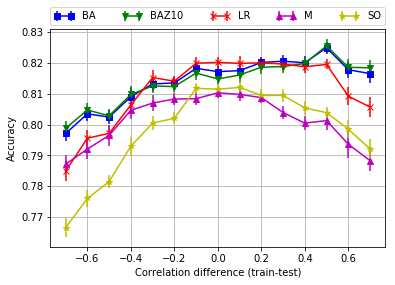

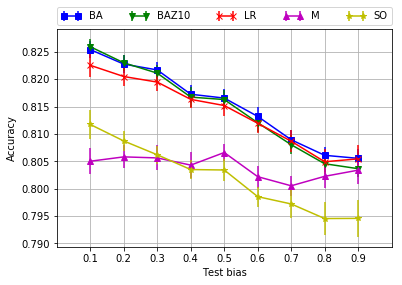

In [16]:
# Export IMDb plots
fig = export_plot_accuracy('../paper/figures/imdb_accuracy_corr_diff.pdf',
                           accuracies, corr_diff_axis, 2, 2, title='',
                           xlabel='Correlation difference (train-test)',
                           ylabel='Accuracy',
                           mask=mask)

fig = export_plot_accuracy('../paper/figures/imdb_accuracy_test_bias.pdf',
                           accuracies, test_bias_axis, 2, 2, title='',
                           xlabel='Test bias',
                           ylabel='Accuracy', xlim=[0.,1.], set_xticks=np.arange(0.1,1.,.1),
                           mask=mask)

### Simpson's paradox

In [17]:
%run simpson_paradox.py
%run models.py

<Figure size 432x288 with 0 Axes>

In [18]:
methods = [('LR', lr), ('BA', backdoor_adjustment), ('BAZ10', backdoor_adjustment_Z10)]
rand = np.random.RandomState(111191)
biases, spa_count_bias_results = simpson_paradox_count_bias(data, methods, 1400, rand=rand)

LR - Bias = 0.1
LR - Bias = 0.2
LR - Bias = 0.30000000000000004
LR - Bias = 0.4
LR - Bias = 0.5
LR - Bias = 0.6
LR - Bias = 0.7000000000000001
LR - Bias = 0.8
LR - Bias = 0.9
BA - Bias = 0.1
BA - Bias = 0.2
BA - Bias = 0.30000000000000004
BA - Bias = 0.4
BA - Bias = 0.5
BA - Bias = 0.6
BA - Bias = 0.7000000000000001
BA - Bias = 0.8
BA - Bias = 0.9
BAZ10 - Bias = 0.1
BAZ10 - Bias = 0.2
BAZ10 - Bias = 0.30000000000000004
BAZ10 - Bias = 0.4
BAZ10 - Bias = 0.5
BAZ10 - Bias = 0.6
BAZ10 - Bias = 0.7000000000000001
BAZ10 - Bias = 0.8
BAZ10 - Bias = 0.9


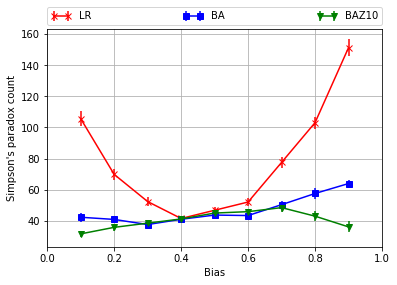

In [19]:
markers = {'LR': 'rx-', 'LRS': 'cD-', 'BA': 'bs-','BAZ10': 'gv-','SO': 'y*-', 'M': 'm^-'}
plot_spa_results(biases, spa_count_bias_results, markers)

### Study effect of C value on accuracy

In [20]:
%run models.py
%run ba_c_study.py

<Figure size 432x288 with 0 Axes>

In [21]:
c_range = np.logspace(-3, 4, 15)
methods = [('BA', backdoor_adjustment_var_C)]
filter_corr_diff = lambda x: np.abs(x) > .6
accuracies_c, coefs_c = do_c_study(c_range, filter_corr_diff, data, 10,
                                   np.random.RandomState(111191), 1400, 5)

5 top correlated features: ['horror' 'gore' 'zombie' 'scary' 'slasher']
train_bias= 0.1 train_corr= -0.3650981952445729 test_bias= 0.8 test_corr= 0.28739664462974956 corr_diff= -0.7
train_bias= 0.1 train_corr= -0.3650981952445729 test_bias= 0.9 test_corr= 0.38319552617299935 corr_diff= -0.7
train_bias= 0.2 train_corr= -0.27382364643342966 test_bias= 0.9 test_corr= 0.38319552617299935 corr_diff= -0.7
train_bias= 0.8 train_corr= 0.27382364643342966 test_bias= 0.1 test_corr= -0.38319552617299957 corr_diff= 0.7
train_bias= 0.9 train_corr= 0.3650981952445729 test_bias= 0.1 test_corr= -0.38319552617299957 corr_diff= 0.7
train_bias= 0.9 train_corr= 0.3650981952445729 test_bias= 0.2 test_corr= -0.2873966446297496 corr_diff= 0.7


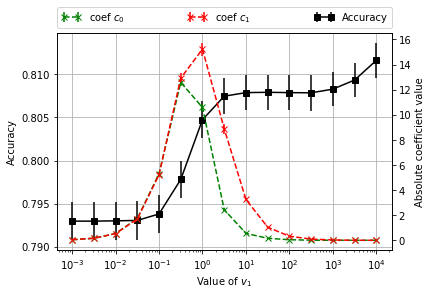

In [22]:
plot_c_study(c_range, accuracies_c, coefs_c, tofile='test.pdf')

### Change in model coefficients

In [23]:
%run most_changing_coef.py

<Figure size 432x288 with 0 Axes>

bias = 0.1


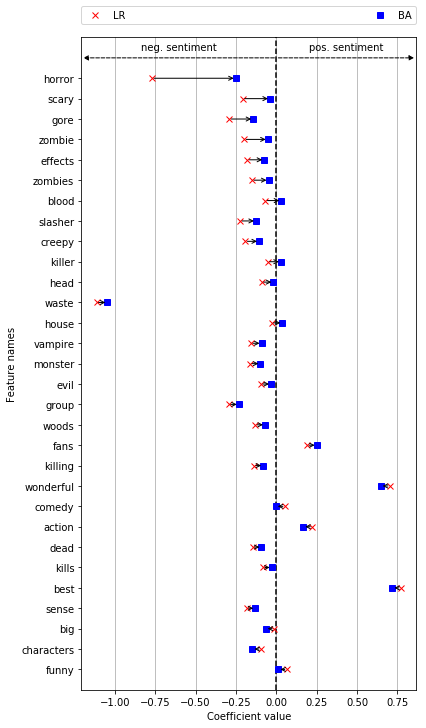

bias = 0.5


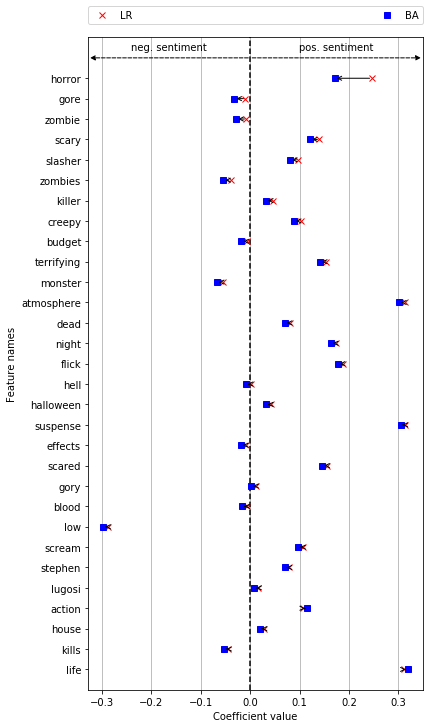

bias = 0.9


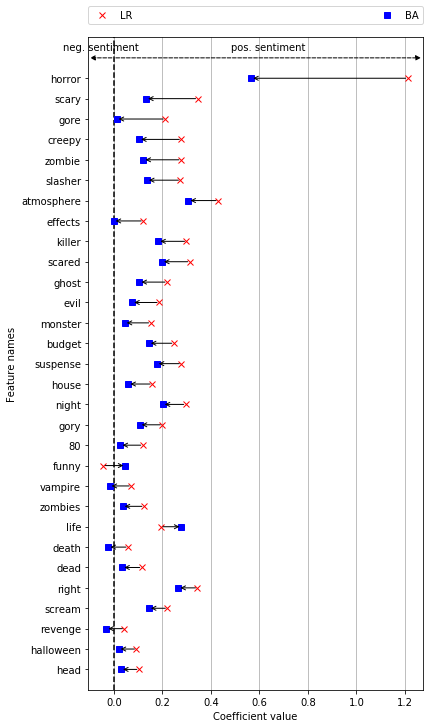

In [24]:
params = dict(data=data,
              n=30,
              models=[(lr, 'LR','rx'), (backdoor_adjustment, 'BA','bs')],
              biases=[.1,.5,.9],
              size=1350,
              transformation=most_changing_coef,
              class_labels=['neg. sentiment', 'pos. sentiment'])
changing_coef_plot(**params)

bias = 0.1


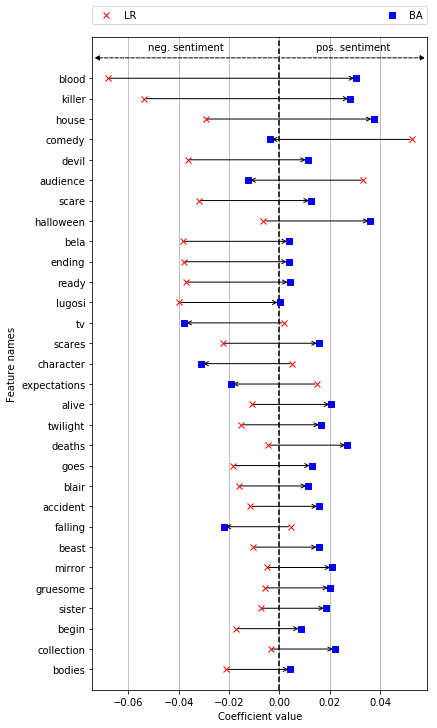

bias = 0.5


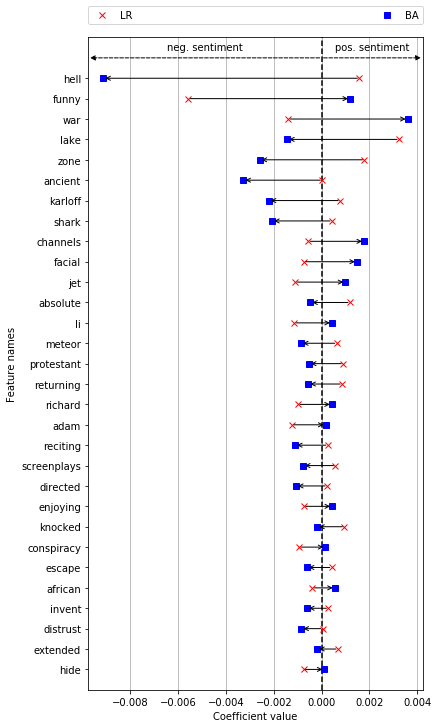

bias = 0.9


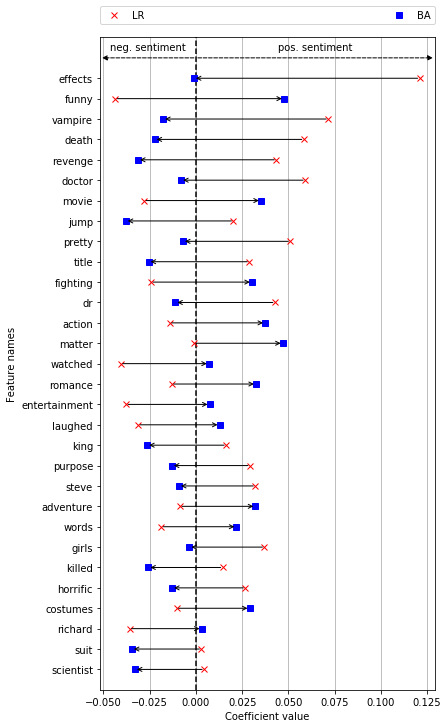

In [25]:
params = dict(data=data,
              n=30,
              models=[(lr, 'LR','rx'), (backdoor_adjustment, 'BA','bs')],
              biases=[.1,.5,.9],
              size=1350,
              transformation=most_changing_sign_coef,
              class_labels=['neg. sentiment', 'pos. sentiment'])
changing_coef_plot(**params)

### Top terms table

In [29]:
%run top_terms_table.py
%run models.py

In [30]:
do_top_coef_table(data, lr, 10, 1400, 30, np.random.RandomState(111191), 1., data.feature_names)

Top 1.00 % of features that are the most correlated with the confounder:
['horror' 'gore' 'zombie' 'scary' 'slasher' 'zombies' 'creepy' 'blood'
 'killer' 'effects' 'gory' 'scares' 'budget' 'vampire' 'monster'
 'halloween' 'vampires' 'dead' 'supernatural' 'kills' 'haunted' 'werewolf'
 'house' 'low' 'creature' 'scared' 'ghost' 'freddy' 'bad' 'scare' 'scream'
 'lugosi' 'atmosphere' '13th' 'nightmare' 'nudity' 'killing' 'elm'
 'spooky' 'cheap' 'flesh' 'flick' 'splatter' 'acting' 'carpenter' 'bela'
 'evil' 'woods' 'night' 'cabin' 'gruesome' 'worst' 'special' 'ghosts'
 'doctor' 'victims' 'slashers' 'dracula' 'bloody' 'suspense' 'undead'
 'gothic' 'hell' 'terrible' 'omen' 'kill' 'deaths' 'pretty' 'scientist'
 'stephen' 'beast' 'genre' 'scariest' 'corpse' 'flicks' 'video' 'friday'
 'killed' 'axe' 'atmospheric' 'eerie' 'starts' 'killings' '80' 'terror'
 'craven' 'murders' 'minutes' 'boll' 'wes' 'poe' 'crap' 'romero' 'fulci'
 'scarier' 'uwe' 'screaming' 'head' 'frightening' 'cheesy' 'fans' 'occu

In [31]:
do_top_coef_table(data, backdoor_adjustment, 10, 1400, 30, np.random.RandomState(111191), 1., data.feature_names)

Top 1.00 % of features that are the most correlated with the confounder:
['horror' 'gore' 'zombie' 'scary' 'slasher' 'zombies' 'creepy' 'blood'
 'killer' 'effects' 'gory' 'scares' 'budget' 'vampire' 'monster'
 'halloween' 'vampires' 'dead' 'supernatural' 'kills' 'haunted' 'werewolf'
 'house' 'low' 'creature' 'scared' 'ghost' 'freddy' 'bad' 'scare' 'scream'
 'lugosi' 'atmosphere' '13th' 'nightmare' 'nudity' 'killing' 'elm'
 'spooky' 'cheap' 'flesh' 'flick' 'splatter' 'acting' 'carpenter' 'bela'
 'evil' 'woods' 'night' 'cabin' 'gruesome' 'worst' 'special' 'ghosts'
 'doctor' 'victims' 'slashers' 'dracula' 'bloody' 'suspense' 'undead'
 'gothic' 'hell' 'terrible' 'omen' 'kill' 'deaths' 'pretty' 'scientist'
 'stephen' 'beast' 'genre' 'scariest' 'corpse' 'flicks' 'video' 'friday'
 'killed' 'axe' 'atmospheric' 'eerie' 'starts' 'killings' '80' 'terror'
 'craven' 'murders' 'minutes' 'boll' 'wes' 'poe' 'crap' 'romero' 'fulci'
 'scarier' 'uwe' 'screaming' 'head' 'frightening' 'cheesy' 'fans' 'occu

In [32]:
do_top_coef_table(data, backdoor_adjustment_Z10, 10, 1400, 30, np.random.RandomState(111191), 1., data.feature_names)

Top 1.00 % of features that are the most correlated with the confounder:
['horror' 'gore' 'zombie' 'scary' 'slasher' 'zombies' 'creepy' 'blood'
 'killer' 'effects' 'gory' 'scares' 'budget' 'vampire' 'monster'
 'halloween' 'vampires' 'dead' 'supernatural' 'kills' 'haunted' 'werewolf'
 'house' 'low' 'creature' 'scared' 'ghost' 'freddy' 'bad' 'scare' 'scream'
 'lugosi' 'atmosphere' '13th' 'nightmare' 'nudity' 'killing' 'elm'
 'spooky' 'cheap' 'flesh' 'flick' 'splatter' 'acting' 'carpenter' 'bela'
 'evil' 'woods' 'night' 'cabin' 'gruesome' 'worst' 'special' 'ghosts'
 'doctor' 'victims' 'slashers' 'dracula' 'bloody' 'suspense' 'undead'
 'gothic' 'hell' 'terrible' 'omen' 'kill' 'deaths' 'pretty' 'scientist'
 'stephen' 'beast' 'genre' 'scariest' 'corpse' 'flicks' 'video' 'friday'
 'killed' 'axe' 'atmospheric' 'eerie' 'starts' 'killings' '80' 'terror'
 'craven' 'murders' 'minutes' 'boll' 'wes' 'poe' 'crap' 'romero' 'fulci'
 'scarier' 'uwe' 'screaming' 'head' 'frightening' 'cheesy' 'fans' 'occu